# Twitter Sentiment Analysis

# 1. Problem description


This project consists in a classification problem, where we try to predict if a  tweet consists of hate speech or not.
The only data that we have access to are the tweets themselves, and the (binary) labels for the train set.

Source:
https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/


In [1]:
# importing modules

import pandas as pd
import numpy as np
import os
from collections import Counter
from unidecode import unidecode

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# custom module
from utils import PoissonNaiveBayes, validation_curve, learning_curve, TfidfEmbeddingVectorizer, ItemSelector

%matplotlib inline 

# 2. Data Extraction and preprocessing

In [2]:
df_train = pd.read_csv("data/train_E6oV3lV.csv", index_col=[0])
df_test = pd.read_csv("data/test_tweets_anuFYb8.csv", index_col=[0])

In [3]:
# to prepare the data, we merge train and test data in a single dataframe
df = pd.concat([df_train, df_test], sort=False)

We should take a look at the data (or a small sample of) to see how it looks like, and understand which kind of preprocessing it needs.

In [4]:
pd.set_option('max_colwidth', 600) # this ensures that we extend the width of the dataframe columns to see its full content
df.head()

,label,tweet
id,,
1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0.0,bihday your majesty
4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0.0,factsguide: society now #motivation


We observe that:

1. Some of the characters are not being correctly decoded. Therefore, we need to apply an extra step on data preparation to handle that.

2. The words after the @'s should correspond to user accounts. Our sample seems to suggest that the references to different users were replaced simply by a '@user' tag. We are going to create a new feature with the number of references to users in a tweet.

3. Apart from the references to other users, we can also distinguish between plain text and hashtags. Hence, we should separate those.

4. We are also going to separate punctuation from the plain text - excluding commas, dots, and apostrophes - and count how many are used in each tweet.

In [5]:
df['tweet'] = df["tweet"].map(unidecode)  # this corrects the incorrected decoded characters we observed above

In [6]:
# counting the occurrences of the label '@user' in the tweet
df['user_count'] = df['tweet'].str.findall("@user").str.len()

# removing the ocurrences of '@user' label in the twiit
# note: we create a new column for this, called 'text', to keep the original tweet as well
df['text'] = df['tweet'].str.replace('@user', ' ', regex=False)  

In [7]:
df["punctuation"] = df["text"].str.replace("[\w\s#,;.']+", "", regex=True)
df["punc_count"] = df["punctuation"].str.len()

In [8]:
# extracting the hashtags to a new column
df['hashtags'] = df['tweet'].str.findall('#\w+').map(lambda x: ' '.join(x))
df['text'] = df['text'].str.replace('#\w+', '', regex=True)

In [9]:
# count hashtags
df['ht_count'] = df['hashtags'].str.split().str.len()

In [10]:
# we apply an extra step to 'text' columns, to santize the strings
df['text'] = df['text'].map(lambda x: x.lower()).str.replace('\W+', ' ', regex=True)

In [11]:
# showing prepared data:
df.head()

,label,tweet,user_count,text,punctuation,punc_count,hashtags,ht_count
id,,,,,,,,
1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,1,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction,,0,#run,1
2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,2,thanks for credit i can t use cause they don t offer wheelchair vans in pdx,,0,#lyft #disapointed #getthanked,3
3,0.0,bihday your majesty,0,bihday your majesty,,0,,0
4,0.0,#model i love u take with u all the time in urd+-!!! ddddd|d|d|,0,i love u take with u all the time in urd ddddd d d,+-!!!|||,8,#model,1
5,0.0,factsguide: society now #motivation,0,factsguide society now,:,1,#motivation,1


# 3. Exploratory Data Analysis

As we did above, we should take a look at data, but now spliting it for the two types of labels (hate and 'non hate' tweets)

In [12]:
# size of train and test data
print('train set size:', len(df_train))
print('test set size:', len(df_test))

train set size: 31962
test set size: 17197


In [13]:
df_train.groupby('label')['tweet'].count() / df_train['tweet'].count()

label
0    0.929854
1    0.070146
Name: tweet, dtype: float64

=> 7% of the tweets have hate speech

## 3.1 How does the hate speech looks like?

In [14]:
df[df["label"] == 1].head(10)

,label,tweet,user_count,text,punctuation,punc_count,hashtags,ht_count
id,,,,,,,,
14,1.0,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot,1,calls middle school build the wall chant,,0,#cnn #michigan #tcot,3
15,1.0,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins,0,no comment in,!,1,#australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins,6
18,1.0,retweet if you agree!,0,retweet if you agree,!,1,,0
24,1.0,@user @user lumpy says i am a . prove it lumpy.,2,lumpy says i am a prove it lumpy,,0,,0
35,1.0,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia,0,it s unbelievable that in the 21st century we d need something like this again,,0,#neverump #xenophobia,2
57,1.0,@user lets fight against #love #peace,1,lets fight against,,0,#love #peace,2
69,1.0,d(c)the white establishment can't have blk folx running around loving themselves and promoting our greatness,0,d c the white establishment can t have blk folx running around loving themselves and promoting our greatness,(),2,,0
78,1.0,"@user hey, white people: you can call people 'white' by @user #race #identity #meda|",2,hey white people you can call people white by,:|,2,#race #identity #meda,3
83,1.0,how the #altright uses &amp; insecurity to lure men into #whitesupremacy,0,how the uses amp insecurity to lure men into,&,1,#altright #whitesupremacy,2


Examples of 'Non hate' speech

In [15]:
df[df["label"] == 0].head(10)

,label,tweet,user_count,text,punctuation,punc_count,hashtags,ht_count
id,,,,,,,,
1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,1,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction,,0,#run,1
2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,2,thanks for credit i can t use cause they don t offer wheelchair vans in pdx,,0,#lyft #disapointed #getthanked,3
3,0.0,bihday your majesty,0,bihday your majesty,,0,,0
4,0.0,#model i love u take with u all the time in urd+-!!! ddddd|d|d|,0,i love u take with u all the time in urd ddddd d d,+-!!!|||,8,#model,1
5,0.0,factsguide: society now #motivation,0,factsguide society now,:,1,#motivation,1
6,0.0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,0,2 2 huge fan fare and big talking before they leave chaos and pay disputes when they get there,[/],3,#allshowandnogo,1
7,0.0,@user camping tomorrow @user @user @user @user @user @user @user dannya|,8,camping tomorrow dannya,|,1,,0
8,0.0,the next school year is the year for exams.d- can't think about that d #school #exams #hate #imagine #actorslife #revolutionschool #girl,0,the next school year is the year for exams d can t think about that d,-,1,#school #exams #hate #imagine #actorslife #revolutionschool #girl,7
9,0.0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers a|,0,we won love the land a,!!!!!!|,7,#allin #cavs #champions #cleveland #clevelandcavaliers,5


## 3.2 Most frequent Hashtags

In [16]:
# we create a counter of hashtags - only for train data
htPerTweet = df['hashtags'].map(lambda s: Counter(s.split()))
htCount_0 = htPerTweet[df['label'] == 0].sum()
htCount_1 = htPerTweet[df['label'] == 1].sum()
htCount = htCount_0 + htCount_1

In [17]:
table = pd.DataFrame({'tot': htCount, 0: htCount_0, 1: htCount_1}).fillna(0)

In [18]:
# most frequency hash tags - both hate and non hte speech
table.sort_values(by='tot', ascending=False).head()

,tot,0,1
#love,1542,1531.0,11.0
#positive,874,874.0,0.0
#healthy,571,570.0,1.0
#smile,548,548.0,0.0
#thankful,491,491.0,0.0


In [19]:
# most frequenct hashtags for hatespeech
table.sort_values(by=1, ascending=False).head()

,tot,0,1
#trump,176,43.0,133.0
#politics,99,5.0,94.0
#allahsoil,92,0.0,92.0
#libtard,77,1.0,76.0
#liberal,78,3.0,75.0


## 3.3 Can 'user_count', 'ht_count' or 'punc_count' features spot hate speech?

In [20]:
df.groupby('label').agg({'user_count': [np.mean, np.std], 'ht_count': [np.mean, np.std], 'punc_count': [np.mean, np.std]})

user_count            ht_count           punc_count          
            mean       std      mean       std       mean       std
label                                                              
0.0     0.528533  0.971373  2.405821  2.530931   1.504004  2.183570
1.0     0.830955  1.097019  2.138715  2.063241   1.384032  1.539361

We conclude that those features alone cannot be used to spot hate speech.

Considering a law $X\mid Y\sim\mathcal{N}\left(\mu_Y,\sigma_Y\right)$ for each of those counts, to state that $\mu_{Y=1}\neq\mu_{Y=0}$ with, for instance 90% confidence, would require $|\mu_1  -\mu_0|>1.64 \sqrt{\sigma_0^2 +\sigma_1^2}$, which if far from being the case.

# 4. Prediction

## 4.1 Poisson Naive Bayes Model

The Poisson Bayes Model is an attempt to model label data $y$ with a probability distribution $P(y\mid X)$, where $X$ are the features.


1. **The 'Bayes' part:** In some cases it is more natural to model $P(X|y)$ instead of $P(y\mid X)$. The bayes law relates these two conditional probabilities through $P\left(y\mid X\right)=P\left(X\mid y\right)\cdot\frac{P(y)}{P(X)}$. Furthermore, assuming that the set of possible labels is discrete (in this case y is 0 or 1), we can write $P\left(y_k\mid X\right) =P\left( X\mid y\right) \cdot\frac{P\left( y_k\right)}{Z}$, where $Z = \sum_k P(y_k)\cdot P\left( X\mid y_k \right)$. (in the continuous case we can use an integral instead of a sum).


2. **The 'Naive' part** comes from the assumption that the different features $X=\left(x_1, \cdots,x_n\right)$ are independent (conditional to each label), i.e, it is assumed that $P\left(X\mid y_k\right) =P\left( x_1\mid y_k\right)\cdots P\left( x_n\mid y_k\right)\forall k$.


3. **The 'Poisson' part** comes from the probability family distribution we choose for model each $P\left(x_i\mid y_k\right)$. In this case, because we are dealing with count data, it is suitable to choose a poisson distribution $x_i|y_k\sim Poi(\lambda_{ik})$, which depends only on one parameter $\lambda$, which is equal to its expectation.

### 4.1.1 Training

In a training stage, we need to determine the $\lambda_{ik}$ parameters, using training data.

1. If our prior assumption for this parameter is uniform then we only need to make a straighfoward use of the frequencies from the training set.
   Therefore, for a given word $x_i$ and a given class $y_k$ our estimation is:
   $$\lambda_{ik} = \frac{\#\{tweet\mid tweet\in S_k, x_i\in tweet\} }{\#S_k}$$
   Where each $S_k$ is the set of tweets with label $k$
   
&rarr; Having a uniform prior can lead to issues when applying the model to new tweets with new words, because $p\left(x\mid \lambda=0\right)=0 \,\forall x>0$

We should then have a prior assumption, equivalent to observe $n$ tweets with an observation rate $\theta_k$.

2. Under the informal description we made above, we know that the conjugate prior for the poisson distribution is a gamma distribution $\Gamma$ with parameters $\alpha_{prior}=n\cdot\theta_k$ and $\beta_{prior}=n$.

After the observation (using train data), we get a posterior distribution with parameters  $\alpha_{posterior}=n\cdot\theta_k+\#\{tweet\mid tweet\in S_k, x_i\in tweet\}$ and $\beta_{posterior}=n + \#S_k$.

Therefore our final estimation for $\lambda$ is:
$$\lambda_{ik} = \frac{\#\{tweet\mid tweet\in S_k, x_i\in tweet\} + n\cdot\theta_k }{\#S_k + n}$$

$$\theta_k=\frac{\#\{(x, t)\in S_k\times L\mid x\in t\}}{\#S_k \#L}$$
$L$ is the vocabulary of words appearing in the train set.

### 4.1.2 Prediction

After calibrating the model, we need to do a prediction for validation or test data.
As described previously we will relly on $P\left(y_k\mid X\right) =\frac{P\left( y_k\right)}{Z} \cdot \prod_i P\left( x_i\mid y_k\right)$

For the poisson case this leads to $$P\left(y_k\mid X\right) = \frac{P\left( y_k\right)}{Z}\cdot \exp{\left(\sum_i \left(x_i\cdot \log\lambda_{ik} - \lambda_{ik}\right)\right)} $$

Where $Z$ is a new normalization constant.

After this digression over the theory, we can implement a model under the Scikit-learn API interface.

(Note: this was defined in a file apart - tmp_module.py - to handle a jupyter bug when using the joblib module)

### 3.1.3 Algorithm evaluation

To evaluate the performance of a predictive algorithm, it is needed to use new data that was not previously used to fit the model.

As the samples we have access are scarce, one way to extract more from it and obtain a more precise result is to apply cross-validation.

We will split the initial training set into 3 parts (3-fold cross-validation) and train the model using two parts and measure its score using the remaining part (validation set). After, we can rotate our blocks and repeat the same procedure, k-1 times.

The scoring metric we use is given by $F_1=2\cdot\frac{precision\cdot recall}{precision+recall}$

where $precision = \frac{TRUE\,POSITIVE}{TRUE\,POSITIVE + FALSE\,POSITIVE}$, $recall = \frac{TRUE\,POSITIVE}{TRUE\,POSITIVE + FALSE\,NEGATIVE}$

One of the advantages of the F1 score is that it takes into consideration the impact of precision and recall simultaneously.

In [20]:
# we use both 'text' and 'hashtags' as features
X = (df['text'] + " " + df["hashtags"]).str.strip().str.replace("\s+", " ").str.split(" ").map(Counter)
y = df['label']
X_train = X[y.notnull()]
y_train = y[y.notnull()]
X_test = X[y.isnull()]

In [22]:
clf = PoissonNaiveBayes(n=1)

In [23]:
f1scores = cross_val_score(clf, X_train.values, y_train.values, scoring="f1", cv=3, n_jobs=4)

The mean score we obtain is:

In [24]:
print(f1scores.mean(), "+-", f1scores.std())

0.2154438513120447 +- 0.011262244428967214


We fit now the model to the whole dataset to make our final submission in the website:

In [25]:
clf.fit(X_train, y_train)

PoissonNaiveBayes(n=1)

In [31]:
# function to create a dataframe for submission, with the right format
def submission(clf, X):
    y_pred = 1.0 * clf.predict(X)
    idx = pd.Index(X.index)
    idx.name = 'id'
    return pd.DataFrame({'label': y_pred}, index=idx)

In [27]:
# saving submission
submission(clf, X_test).to_csv("submissions/naive_n1.csv")

Score from submission (test set): 0.2287188306104901

### 3.1.4 Hyperparameter Tuning

The regularization parameter $n$ was set to 1 in the previous example. However, we can make our predictions using other values of n and evaluate the new scores, using cross validation.

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of  30 | elapsed:  7.1min remaining: 63.9min
[Parallel(n_jobs=8)]: Done   7 out of  30 | elapsed:  7.6min remaining: 25.1min
[Parallel(n_jobs=8)]: Done  11 out of  30 | elapsed: 14.2min remaining: 24.5min
[Parallel(n_jobs=8)]: Done  15 out of  30 | elapsed: 15.2min remaining: 15.2min
[Parallel(n_jobs=8)]: Done  19 out of  30 | elapsed: 21.5min remaining: 12.4min
[Parallel(n_jobs=8)]: Done  23 out of  30 | elapsed: 22.9min remaining:  7.0min
[Parallel(n_jobs=8)]: Done  27 out of  30 | elapsed: 28.0min remaining:  3.1min
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 28.7min finished


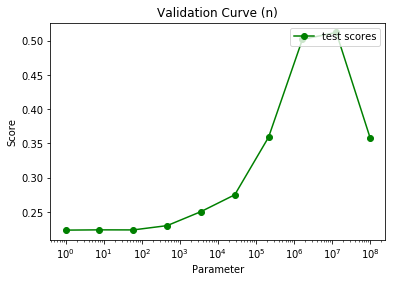

In [28]:
# the validation_curve function is defined in tmp_module.py
validation_curve(clf, X_train, y_train, 'f1', 'n', 0, 8, n_points=10, log_scale=True, train_curve=False, cv=3, n_jobs=8)

-> the choice of $n$ as a big impact on the final score.

We choose $n=10^6$

In [29]:
clf = PoissonNaiveBayes(n=1e6)

In [30]:
f1scores = cross_val_score(clf, X_train.values, y_train.values, scoring="f1", cv=3, n_jobs=4)

With the new hyperparameter $n$, the score we obtain is:

In [31]:
print(f1scores.mean(), "+-", f1scores.std())

0.4743551789672206 +- 0.008058906361705717


In [33]:
clf.fit(X_train, y_train)  # We fit now the model to the whole dataset to make our final submission in the website

# saving submission
submission(clf, X_test).to_csv("naive_n10_6_submission.csv")

Score from submission (test set): 0.4054910242872228

### 4.2 Logistic Regression

Other model we can use is the Logistic Regression: $y=s\left(A\cdot X\right)$, where $s: t \mapsto \frac{1}{1+e^{-t}}$ is the sigmoid function.

We will use plain text and hashtags from tweets as features, however, in this case we will apply a tf-idf transformation instead of using straight word counts.

The tf-idf transformation increases the weight of words that are less frequent among the among the set of tweets. 

In [21]:
lr = make_pipeline(TfidfVectorizer(), LogisticRegression())

In [22]:
X = (df['text'] + " " + df["hashtags"]).str.strip().str.replace("\s+", " ")
y = df['label']
X_train = X[y.notnull()]
y_train = y[y.notnull()]
X_test = X[y.isnull()]

In [23]:
f1scores = cross_val_score(lr, X_train.values, y_train.values, scoring="f1", cv=3, n_jobs=4)

With the standard hyperparameter $C=1$ (we are considering $l_2$ regularization), the mean score we obtain is:

In [24]:
print(f1scores.mean(), "+-", f1scores.std())

0.4046366833196638 +- 0.018857920813160563


##### Hyperparameter tunning:

[Parallel(n_jobs=8)]: Done   3 out of  30 | elapsed:    6.5s remaining:   59.0s
[Parallel(n_jobs=8)]: Done   7 out of  30 | elapsed:   11.0s remaining:   36.4s
[Parallel(n_jobs=8)]: Done  11 out of  30 | elapsed:   14.2s remaining:   24.6s
[Parallel(n_jobs=8)]: Done  15 out of  30 | elapsed:   17.5s remaining:   17.5s
[Parallel(n_jobs=8)]: Done  19 out of  30 | elapsed:   20.3s remaining:   11.7s
[Parallel(n_jobs=8)]: Done  23 out of  30 | elapsed:   23.8s remaining:    7.2s
[Parallel(n_jobs=8)]: Done  27 out of  30 | elapsed:   25.4s remaining:    2.7s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:   25.9s finished


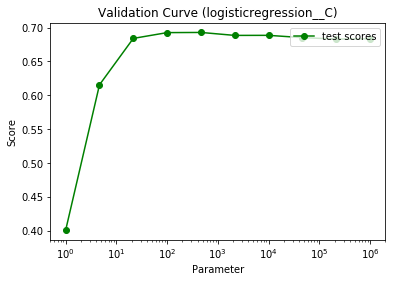

In [25]:
validation_curve(lr, X_train, y_train, 'f1', 'logisticregression__C', 0, 6, n_points=10, log_scale=True, train_curve=False, cv=3, n_jobs=8)

Based on the validation curve above we choose $C=10^2$ as regularization parameter.

In [26]:
lr = make_pipeline(TfidfVectorizer(), LogisticRegression(C=1e2))

In [27]:
f1scores = cross_val_score(lr, X_train.values, y_train.values, scoring="f1", cv=3, n_jobs=4)

With the new hyperparameter $C=10^6$, the mean score we obtain is:

In [28]:
print(f1scores.mean(), "+-", f1scores.std())

0.6930359842606709 +- 0.016879505645661024


We fit now the model to the whole dataset to make our final submission in the website:

In [29]:
lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [32]:
# saving submission
submission(lr, X_test).to_csv("submissions/regression.csv")

Score from submission (test set): 0.749615975422427

### 4.2.1 Learning Curve

The learning curve shows how well an algorithm perform as a function of the size of the training set.

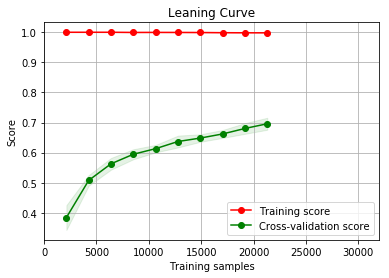

In [33]:
learning_curve(lr, X_train, y_train, scoring='f1', n_min=.1, n_max=1, n_points=10, log_scale=False, cv=3, n_jobs=4)

The graph indicates that the model suffers has high variance – it tends to overfit the training data and does not generalize well to unseen data - which is likely to reduce if more training data is provided.

### 4.2.2 Using other features

Instead of using tf-idf directly, we can use other features and combinations of transformations to feed the logistic regression:

In [34]:
lr2 = make_pipeline(
    make_union(
        make_pipeline(ItemSelector('text'), TfidfVectorizer()),
        make_pipeline(ItemSelector('hashtags'), TfidfVectorizer()),
        make_pipeline(ItemSelector(['user_count', 'punc_count', 'ht_count']), StandardScaler())),
    LogisticRegression(C=1e2))

In [35]:
X_train  = df[df['label'].notnull()]
y_train = df['label'][df['label'].notnull()]
X_test = df[df['label'].isnull()]

In [36]:
f1scores = cross_val_score(lr2, X_train, y_train, scoring="f1", cv=3, n_jobs=4)

In [37]:
print(f1scores.mean(), "+-", f1scores.std())

0.6949139268943805 +- 0.018293252577563507


In [38]:
lr2.fit(X_train, y_train)

# saving submission
submission(lr2, X_test).to_csv("submissions/regression2.csv")

Score from submission (test set): 0.7473200612557427

-> we conclude that the model doesn't improve by using the new features

### 4.2.3 Extracting word meaning using Word2Vec

We can use a pre-trained model to map from words to vectors of real numbers in a vectorial space with much lower dimension.
With word2vec this map should respect semantic relations between words to the maximum. Therefore, words with a similar meaning must be mapped to vectors that are close to each other, even if their lexicon is very different.

In [13]:
# file extracted from https://drive.google.com/uc?export=download&confirm=TpPo&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
from gensim.models.keyedvectors import KeyedVectors
dico = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
tf = TfidfEmbeddingVectorizer(dico)  # model defined in tmp_module.py

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


we apply the same pipeline as in the previous examples:

In [14]:
lr_w2v = make_pipeline(
    make_union(
        make_pipeline(ItemSelector('text'), TfidfVectorizer()),
        make_pipeline(ItemSelector('hashtags'), TfidfVectorizer()),
        make_pipeline(ItemSelector('text'), tf)),
    LogisticRegression(C=1e2))

[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:  9.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed: 13.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed: 17.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed: 20.4min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed: 22.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed: 30.6min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed: 76.2min finished


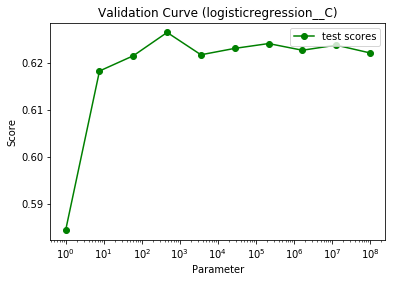

In [17]:
validation_curve(lr_w2v, X_train, y_train, 'f1', 'logisticregression__C', 0, 8, n_points=10, log_scale=True, train_curve=False, cv=3, n_jobs=8)

In [23]:
lr_w2v.steps[1][1].C = 1e3

In [24]:
f1scores = cross_val_score(lr_w2v, X_train, y_train, scoring="f1", cv=3)

In [25]:
print(f1scores.mean(), "+-", f1scores.std())

0.6297846518294202 +- 0.03947178403142573


In [26]:
lr_w2v.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(memory=None,
     steps=[('itemselector', ItemSelector(key='text')), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [27]:
submission(lr_w2v, X_test).to_csv("submissions/w2v.csv")

Score from submission (test set): 0.6301369863013699

## 5. Conclusion and recommendations

In this project, we analysed if tweets consisted of hate speech or not, just looking at their content.

One of the first conclusions we reach is that correlation between features matters. This is the main reason why Naïve Bayes performance is so poor compared with the Logistic Regression. We can understand this intuitively: there are words that usually only appear coupled with another one.

A second conclusion is that using more complex models and more features don't lead to better results necessarily. We observed this in point 4.2.2 where we made use of '@user' tags count and punctuation count features, and in point 4.2.3, where we used Word2Vec together with a logistic regression.

Although we didn’t make an extensive analysis, the logistic regression with tf-idf, proved to be quite efficient compared with the other models.
Observing the behaviour of the learning curve, we can also infer that this model will increase its performance if more training data is available. 
Therefore, one recommendation is to try to get more training data, before digging in more complex models.